Urban Data Science & Smart Cities <br>
URSP688Y Spring 2025<br>
Instructor: Chester Harvey <br>
Urban Studies & Planning <br>
National Center for Smart Growth <br>
University of Maryland

# Demo 10 - Spatial Visualization

Today we'll be talking about visualizing spatial data, more colloquially known as making maps. Like other data visualization in Python, mapping is essentially just drawing in Cartesian space. Maps, however, introduce some particularities around coordinate reference systems (projections). They can also be supplemented with base layers showing reference data. The ubiquity of web maps nowadays also compels us to develop interactive maps that let us pan, zoom, and click on objects to get more information. Luckily, some packages make developing maps with Python fairly straightforward, though it can still take some work to refine them visually.

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## GeoPandas `plot`

The simplest option for making a static map from a GeoDataFrame is the built-in `plot` method.

In [2]:
crs = 26918 # UTM18
affordable_housing = gpd.read_file('affordable_housing.geojson').to_crs(crs)
tracts = gpd.read_file('dc_tracts.geojson').to_crs(crs)
# Restrict to tract-level features, which have geoids 18 characters long
tracts = tracts[tracts.geoid.str.len() == 18]

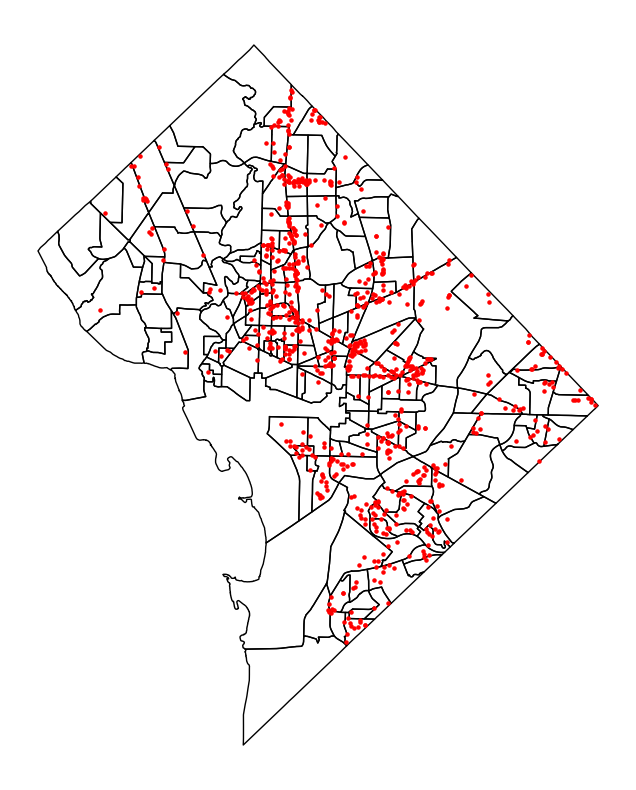

In [3]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = tracts.plot(ax=ax, facecolor='none', edgecolor='k', zorder=0)
affordable_housing.plot(ax=ax, markersize=5, color='r', zorder=1)
ax.axis('off')

plt.savefig('large_scale_map.eps')

plt.show()

In [4]:
affordable_housing = affordable_housing.sjoin(tracts[['geoid','geometry']])

In [5]:
tracts = tracts.set_index('geoid')

In [6]:
tracts = pd.concat([tracts, affordable_housing.groupby('geoid').agg({'TOTAL_AFFORDABLE_UNITS':'sum'})], axis=1)
tracts = tracts.fillna(0)

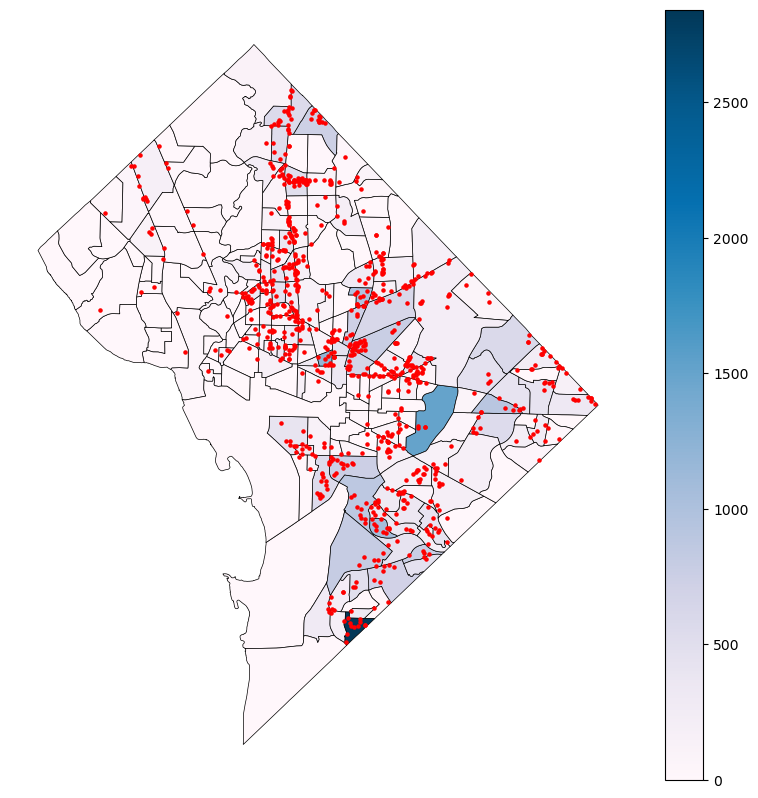

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = tracts.plot(ax=ax, column='TOTAL_AFFORDABLE_UNITS', cmap='PuBu', linewidth=0.5, edgecolor='black', legend=True)
affordable_housing.plot(ax=ax, markersize=5, color='r', zorder=1)
ax.axis('off')

plt.savefig('large_scale_map.eps')

plt.show()

In [8]:
tracts['affordable_units_per_pop'] = tracts['TOTAL_AFFORDABLE_UNITS'] / tracts['B01003001']

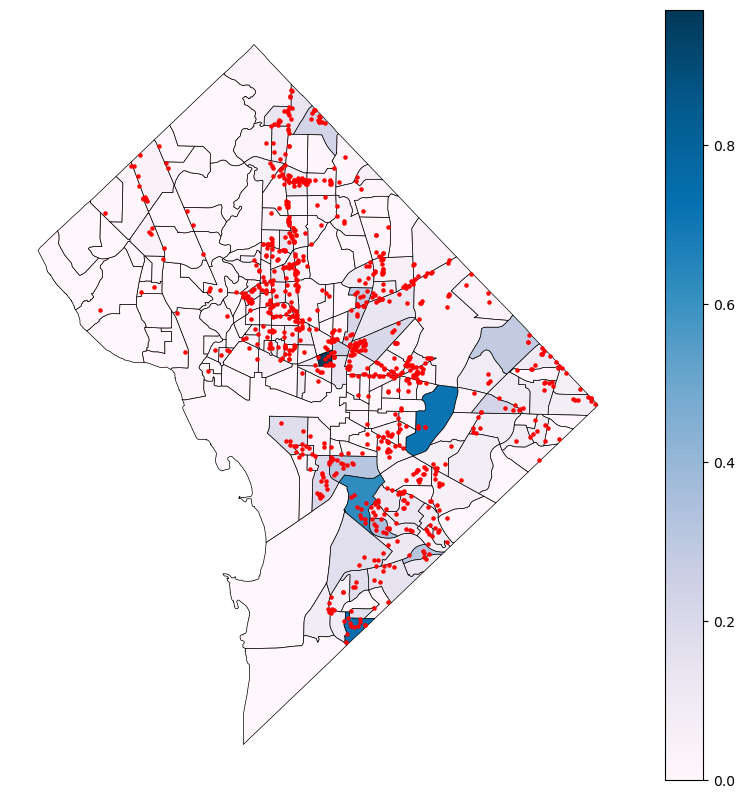

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = tracts.plot(ax=ax, column='affordable_units_per_pop', cmap='PuBu', linewidth=0.5, edgecolor='black', legend=True)
affordable_housing.plot(ax=ax, markersize=5, color='r', zorder=1)
ax.axis('off')

plt.savefig('large_scale_map.eps')

plt.show()

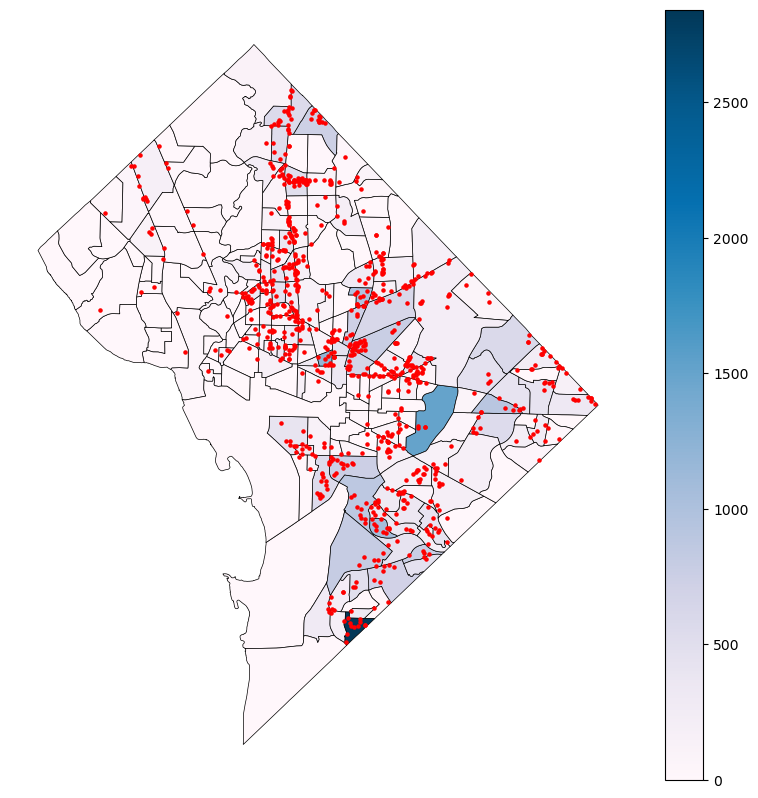

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = tracts.plot(ax=ax, column='TOTAL_AFFORDABLE_UNITS', cmap='PuBu', linewidth=0.5, edgecolor='black', legend=True)
affordable_housing.plot(ax=ax, markersize=5, color='r', zorder=1)
ax.axis('off')

plt.savefig('large_scale_map.eps')

plt.show()

### Proportional Symbol Map

An elegant way to map counts without biasing by the areas of spatial units is to use proportional symbols. This script calculates the radii (buffer distances) for circular symbols with areas proportional to input counts. 

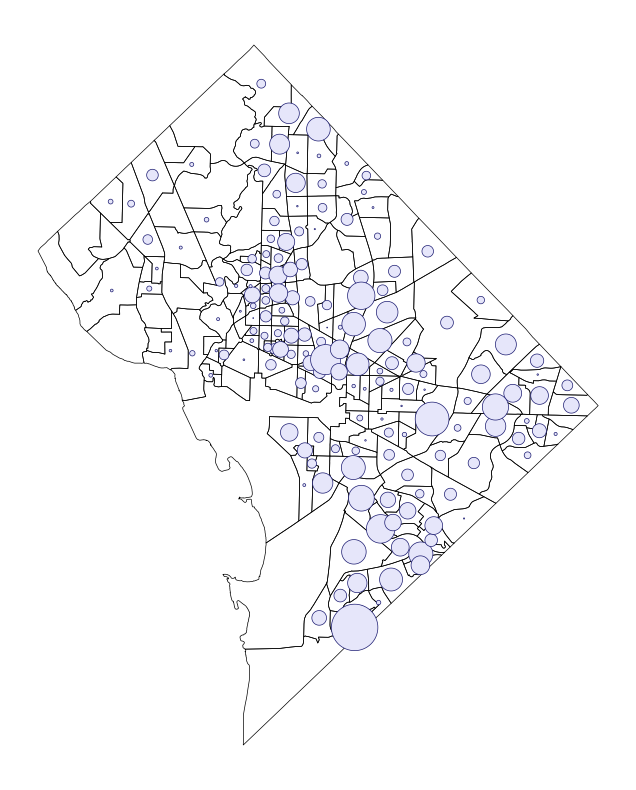

In [11]:
tract_points = tracts.copy()
tract_points['geometry'] = tract_points.centroid

def proportional_circles_radii(values, multiplier=1):
    return np.sqrt(values / 3.14) * multiplier

fig, ax = plt.subplots(figsize=(10, 10))
ax = tracts.plot(ax=ax, facecolor='none', edgecolor='black', zorder=0, linewidth=0.5)

tract_points.buffer(proportional_circles_radii(tract_points['TOTAL_AFFORDABLE_UNITS'], 25)).plot(
    ax=ax, 
    zorder=1, 
    facecolor='lavender', 
    edgecolor='midnightblue', 
    linewidth=0.5)
# affordable_housing.plot(ax=ax, markersize=1, color='darkblue', zorder=2)
ax.axis('off')

plt.savefig('large_scale_map.eps')

plt.show()

## Contextly can automatically add a basemap for reference

In [12]:
# !pip install contextily

In [13]:
import contextily as cx

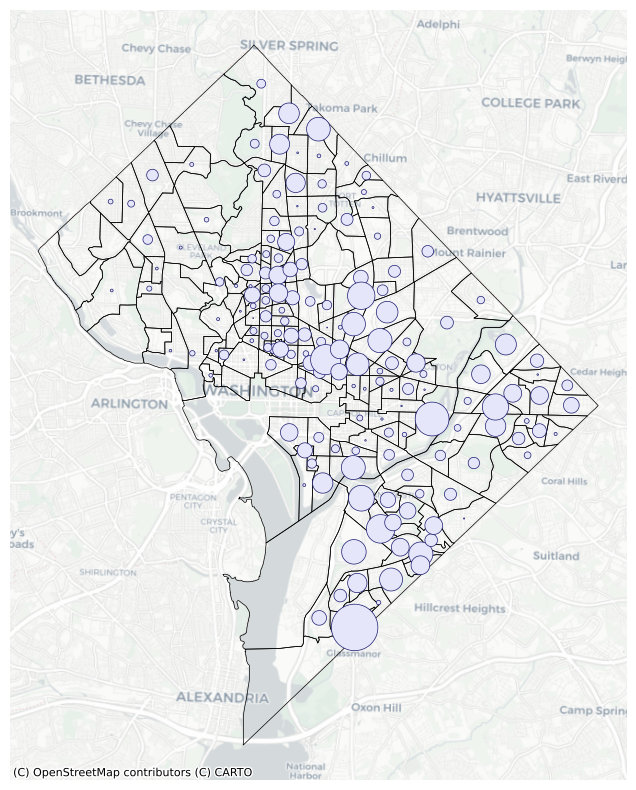

In [14]:
tract_points = tracts.copy()
tract_points['geometry'] = tract_points.centroid

def proportional_circles_radii(values, multiplier=1):
    return np.sqrt(values / 3.14) * multiplier

fig, ax = plt.subplots(figsize=(10, 10))
ax = tracts.plot(ax=ax, facecolor='none', edgecolor='k', zorder=1, linewidth=0.5)

tract_points.buffer(proportional_circles_radii(tract_points['TOTAL_AFFORDABLE_UNITS'], 25)).plot(
    ax=ax, 
    facecolor='lavender', 
    edgecolor='midnightblue', 
    linewidth=0.5, 
    zorder=2)
ax.axis('off')

# Base map with labels embedded
cx.add_basemap(ax, crs=crs, source=cx.providers.CartoDB.Positron, zorder=0)

# Base map with labels overlaid
# cx.add_basemap(ax, crs=crs, source=cx.providers.CartoDB.PositronNoLabels, zorder=0)
# cx.add_basemap(ax, crs=crs, source=cx.providers.CartoDB.PositronOnlyLabels, zorder=3)

plt.savefig('large_scale_map.eps')

plt.show()

## Folium

To make an interactive map with the popular [Leaflet.js](https://leafletjs.com/reference) JavaScript library, we can use Folium.

In [15]:
# !pip install folium

In [16]:
import folium

In [17]:
affordable_housing = gpd.read_file('affordable_housing.geojson')
tracts = gpd.read_file('dc_tracts.geojson')

# Project into lat and long (WGS84)
affordable_housing = affordable_housing.to_crs(4326)
tracts = tracts.to_crs(4326)

# Drop column with timestamps because they interfere with Folium
affordable_housing = affordable_housing.drop(columns=['GIS_LAST_MOD_DTTM'])

# Identify map center
lon_min, lat_min, lon_max, lat_max = tracts.total_bounds
lon_center = (lon_max + lon_min) / 2
lat_center = (lat_max + lat_min) / 2

# Initiate map
map = folium.Map(location=(lat_center, lon_center), zoom_start=12)
# map = folium.Map(location=(lat_center, lon_center), zoom_start=12, tiles="Cartodb Positron")

# Add tracts
tract_style = {
    'weight': 1,
    'color': 'black',
    'fillColor': '#00000000',
    'fillOpacity': 1,
    }
folium.GeoJson(data=tracts.to_json(), style_function=lambda x: tract_style).add_to(map)

# Add affordable housing points
circle_marker = folium.CircleMarker(radius = 4, weight = 1, color='white', fillColor = 'darkblue', fill_opacity=1)
affordable_housing_points = folium.GeoJson(affordable_housing.to_json(), marker=circle_marker)
folium.features.GeoJsonPopup(fields=['PROJECT_NAME','TOTAL_AFFORDABLE_UNITS'], labels=True).add_to(affordable_housing_points)
affordable_housing_points.add_to(map)

map

## GeoPandas `explore`

To make life just a little easier, GeoPandas has a built-in method for making a Folium map with `explore`.

In [22]:
m = tracts.explore(
    tiles='CartoDB positron',
    attr='MapBox CartoDB positron',
    style_kwds={
        'weight': 1,
        'color': 'black',
        'fillColor': '#00000000',
        'fillOpacity': 1,
    },
)

m = affordable_housing.explore(
    m=m,
    marker_kwds={
        'radius':4, 
        'weight':1, 
        'color':'white', 
        'fillColor':'darkblue', 
        'fill_opacity':1
    },
)

m

## CartoPy

If you're making a smaller-scale map of a state, country, or continent (can you guess why the scale is called "smaller"?) you may need to use a specialized projection to avoid distortion or preserve particular qualities (e.g., using an equidistant projection to allow for measurement between distant points).

A package called CartoPy enables mapping in Python with nearly any projection. It also allows you to access convenient base layers from [Natural Earth](https://www.naturalearthdata.com/), a free database of global basemap data for cultural (e.g., borders) and physical (e.g., coastlines) features.

In [19]:
# !pip install cartopy

In [20]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


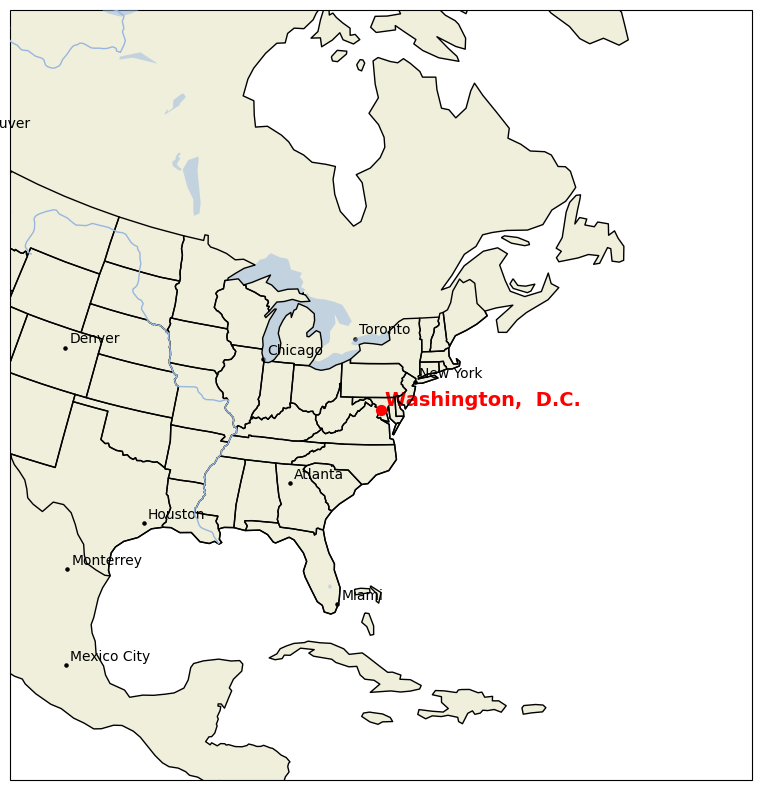

In [21]:
# Define highlight city
highlight_city = 'Washington,  D.C.'
# highlight_city = 'Chicago'

# Load city points
pop_places = gpd.read_file('ne_10m_populated_places_simple.zip')

# Define map center and extents around the highlight city
lon_center = pop_places[pop_places['name'] == highlight_city].geometry.x.iloc[0]
lat_center = pop_places[pop_places['name'] == highlight_city].geometry.y.iloc[0]
extent = 50
lon_min = lon_center + (extent / 2)
lon_max = lon_center - (extent / 2)
lat_min = lat_center - (extent / 2)
lat_max = lat_center + (extent / 2)

# Define projection centered on highlight city
crs = ccrs.AzimuthalEquidistant(central_longitude=lon_center, central_latitude=lat_center)

# Project cities into axis coordinate system
pop_places = pop_places.to_crs(crs.proj4_init)

# Constrain to cities only one rank lower than the highlight
rank = pop_places[pop_places['name'] == highlight_city].scalerank.iloc[0] + 1
pop_places = pop_places[pop_places.scalerank <= rank]

# Initiate figure
fig = plt.figure(figsize=(15, 10))

# Initiate axis with defined projection
ax = plt.subplot(1, 1, 1, projection=crs)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add base features
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='blue', linestyle='--', zorder=0)
ax.add_feature(cfeature.LAND, zorder=1)
ax.add_feature(cfeature.COASTLINE, zorder=2)
ax.add_feature(cfeature.LAKES, alpha=0.5, zorder=3)
ax.add_feature(cfeature.STATES, zorder=4)
ax.add_feature(cfeature.RIVERS, zorder=5)

# Add city points
pop_places.plot(ax=ax, markersize=5, color='k', zorder=1)
pop_places[pop_places['name'] == highlight_city].plot(ax=ax, markersize=50, color='r', zorder=6)

# Label cities
def annotate(record):
    if record['name'] == highlight_city:
        ax.annotate(record['name'], weight='bold', size=14, color='red', xy=record.geometry.coords[0], xytext=(3, 3), textcoords='offset points', clip_on=True)
    else:
        ax.annotate(record['name'], xy=record.geometry.coords[0], xytext=(3, 3), textcoords='offset points', clip_on=True)
pop_places.apply(annotate, axis=1)

plt.savefig('small_scale_map.eps', format='eps')

plt.show()